/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


            BP   NO   NO2   NOX  RAIN  SOLR  SO2   WDIR  WSPD
175291  1029.0  4.1  12.3  18.6   0.0   5.0  2.3  282.0   0.2
175292  1029.0  4.1  12.3  18.6   0.0   5.0  2.3  282.0   0.2
175293  1029.0  4.1  12.3  18.6   0.0   5.0  2.3  272.0   0.2
175294  1029.0  4.1  12.3  18.6   0.0   5.0  2.3  277.0   0.2
175295  1029.0  4.1  12.3  18.6   0.0   4.0  2.3  268.0   0.2
0.04439760557206221
-0.01824514263430402
0.5692352500786635
0.9381241373411684
-0.24504004075125002
0.017680946049528096
-0.298387925483388
[32.01416412232582, 688.9293003475974, 850411.349891091, 2264976.054750875, 14266.64750210219, 2669.210561361256, 0.68613793116157]
RMSE of distance and attribute weighted knn 2.7984600550149774
MAE for distance and attribute weighted KNN 0.8823819324456919
Time Taken 152.89868545532227


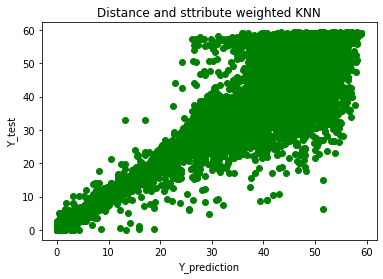

In [1]:
import numpy as np
import pandas as pd
import time
import math
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors.regression import KNeighborsRegressor, check_array, _get_weights
from sklearn.preprocessing import KBinsDiscretizer
from math import log2
from math import log
import matplotlib.pyplot as plt
from statistics import median
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
# from feature_engine.discretisers import EqualWidthDiscretiser
class MedianKNNRegressor(KNeighborsRegressor):
    def predict(self, X):
        X = check_array(X, accept_sparse='csr')

        neigh_dist, neigh_ind = self.kneighbors(X)

        weights = _get_weights(neigh_dist, self.weights)

        _y = self._y
        if _y.ndim == 1:
            _y = _y.reshape((-1, 1))

        ######## Begin modification
        if weights is None:
            y_pred = np.median(_y[neigh_ind], axis=1)
        else:
            # y_pred = weighted_median(_y[neigh_ind], weights, axis=1)
            raise NotImplementedError("weighted median")
        ######### End modification

        if self._y.ndim == 1:
            y_pred = y_pred.ravel()

        return y_pred    

# [  2.38172861  13.3871126    9.6737255    2.77561858  17.07392584]
# # APPLYING PSO
def WeightedAverage(neighbors,distance,test,w,X_train,Y_train,coeff,val):
  # We calculate weights considering y<8
  if True:
    similar=[]
    total=0
    counter=0
    y=0
    n=[]
    d=[]
    x=[]
    z=1
    # print(neighbors)
    # print(distance)

    for i in distance:
      for k in i:
        d.append(k)
        x.append(k)
    for i in neighbors:
      for k in i:
        n.append(k)
        x.append(k)
    # DUAL WEIGHTING FUNCTION
    arr=np.array(x)
    h=arr.reshape((2,val))
    h=h[:,h[0].argsort()]
    columns=list(X_train)
    # h is a 2d array with the first row storing distance, and the second row storing their correspoding indices
    flag=0
    ans=[]
    for i in h[0]:
      if h[0][val-1]!=h[0][0]:
        flag=1
        # z=((h[0][19]-i)/(h[0][19]-h[0][0]))*((h[0][19]+h[0][0])/(h[0][19]+i))
        z=((h[0][val-1]-i)/(h[0][val-1]-h[0][0]))/(i+1)
        similar.append(z)
      # total+=k
      else:
        y=Y_train['NO2'].iloc[int(h[1,0])]
    if flag==1:  
      j=0
      for r in similar:
        total+=r
      # print(neighbors)
      for i in h[1]:
        # print(Y_train['NO'].iloc[i])
        # print("Similar:")
        # print(similar[j]/total)
        # print(total)
        # print(h)
        # print(h[1,j])
        if Y_train['NO2'].iloc[int(h[1,j])]>8:
          counter+=1
        y+=Y_train['NO2'].iloc[int(h[1,j])]*(similar[j]/total)
        j+=1

    return y

#  We now calculate y considering y>8



def kNN(X,w,k,Y):                                  ### This function finds mse
  X_v,X_t,Y_v,Y_t=train_test_split(X,Y,test_size=0.2)
  columns=list(X_v)
  X_temp_v=X_v.copy()
  X_temp_t=X_t.copy()
  j=0
  for i  in columns:
    X_temp_t[i]=X_t[i]*w[j]
    X_temp_v[i]=X_v[i]*w[j]
    j+=1
  knn1=KNeighborsRegressor()
  knn1.fit(X_temp_v,Y_v)
  y_t_p=knn1.predict(X_t)
  return mean_squared_error(Y_t,y_t_p,squared=False)
  
# pso is used to find the weights of features.
# returns weight vector
#objective function is the mse of knn
# hyperparameters itr,c1,c2,w,pop_size
def Bound(v,Pop):
  
  
  rows,columns=np.shape(Pop)                       # Weights can only lie between 0 to 1000 (boundaries chosen) 
  
  
  for i in range(rows):
    for j in range(columns):
      if(v[i][j]+Pop[i][j]>10):
        Pop[i][j]=10
      elif(v[i][j]+Pop[i][j]<0):
        Pop[i][j]=0
      else:
        Pop[i][j]=v[i][j]+Pop[i][j]
  
  
  return Pop
def Best(Pop,pbest,X,Y,k):              # Updates the best objective function value for each value and returns that
  rows,columns=np.shape(Pop)
  pnew=list()
  for i in range(rows):
    if(kNN(X,Pop[i],k,Y)<pbest[i]):
      pnew.append(kNN(X,Pop[i],k,Y))
    else:
      pnew.append(pbest[i])
  pN=np.array(pnew)  
  return pN
def pso(w,c1,c2,itr,X,Y,pop_size,k):
  # particle swarm optimization, Pop list contains the particles, the gbest stores global best. Function returns weight vector (particle)
  #corresponding to gbest
  rows,features=np.shape(X)
  Pop=[float(random.random()*10) for i in range(features*pop_size)]  
  P=np.reshape(Pop,(pop_size,features))
  Pop=P
  f=[kNN(X,P[i],k,Y) for i in range(pop_size)]
  # f contains the values of kNN corresponding to each particle taken as weight vector. It is to pop for sorting ease
  P=np.column_stack((P,np.array(f)))
  
  pbest=np.array(f)
  v1=[float(random.random()*0.5) for i in range(features*pop_size)]
  v=(np.reshape(v1,(pop_size,features)))
  #w=list()
  P=(P[P[:,features].argsort()])
  #w=P[1][0:features]
  # w stores the weight corresponding to gbest
  # each iteration prints the weight vector and corresponding gbest(lowest mse in that iteration)
  
  # print(w)
  gbest=kNN(X,w,k,Y)
  # print(gbest)
  for i in range(itr):
    
    R1=[float(random.random()) for k in range(features)]
    R2=[float(random.random()) for k in range(features)]
    r1=np.array(R1)
    r2=np.array(R2)
    
    
    print(i)
    print(gbest)
    for j in range(pop_size):
      v[j]=w*v[j]+c1*r1*(pbest[j]-Pop[j])+c2*r2*(gbest-Pop[j]) 
      for k in range(features):
        if v[j][k]>0.5:
          v[j][k]=0.5
    # velocity is calculated, and then the new particle weights is obtained after checking boundary condition
    
    
    Pop=Bound(v,Pop)
    pbest=Best(Pop,pbest,X,Y,k)
    
    
    for i in range(pop_size):
      if(pbest[i]<gbest):
        gbest=pbest[i]
        w=Pop[i]
    print(w)
  
    
  return w
begin=time.time()
df=pd.read_csv('/content/drive/MyDrive/SID 2-2/CS F266_ML/PAPER-1/DATA/LaqnData 2014-2015.csv')
df2=pd.read_csv('/content/drive/MyDrive/SID 2-2/CS F266_ML/PAPER-1/DATA/LaqnDataPart2data.csv')
df3=pd.read_csv('/content/drive/MyDrive/SID 2-2/CS F266_ML/PAPER-1/DATA/LaqnData  2015-2017.csv')
df4=pd.read_csv('/content/drive/MyDrive/SID 2-2/CS F266_ML/PAPER-1/DATA/LaqnData 2015-2017Part2.csv')
df5=pd.read_csv('/content/drive/MyDrive/SID 2-2/CS F266_ML/PAPER-1/DATA/LaqnData 2017-2019.csv')
df6=pd.read_csv('/content/drive/MyDrive/SID 2-2/CS F266_ML/PAPER-1/DATA/LaqnData 2017-2019Part2.csv')
df1=pd.DataFrame()
df7=pd.DataFrame()
BP=[]
#date=[]
NO=[]
NO2=[]
NOX=[]
RAIN=[]
RHUM=[]
SOLR=[]
SO2=[]
WDIR=[]
WSPD=[]
#df[df['Value'] < 0]=float('NaN')
#df2[df2['Value'] < 0]=float('NaN')
# j=0
# for i in df['Value']:
#   if i<0:
#     df['Value'][j]=float('NaN')
#   j+=1
# j=0
# for k in df2['Value']:
#   if k<0:
#     df2['Value'][j]=float('NaN')
#   j+=1
for i in df2.index:
    if df2['Species'][i]=='SOLR':
        SOLR.append(df2['Value'][i])
    if df2['Species'][i]=='SO2':
        SO2.append(df2['Value'][i])
    if df2['Species'][i]=='WDIR':
        WDIR.append(df2['Value'][i])
    if df2['Species'][i]=='WSPD':
        WSPD.append(df2['Value'][i])

for i in df.index:
    if df['Species'][i]=='BP':
        BP.append(df['Value'][i])
        
    if df['Species'][i]=='NO':
        NO.append(df['Value'][i])
    if df['Species'][i]=='NO2':
        NO2.append(df['Value'][i])
    if df['Species'][i]=="NOX":
        NOX.append(df['Value'][i])
    if df['Species'][i]=='RAIN':
        RAIN.append(df['Value'][i])
    if df['Species'][i]=='RHUM':
        RHUM.append(df['Value'][i])
# j=0
# for i in df3['Value']:
#   if i<0:
#     df3['Value'][j]=float('NaN')
#   j+=1
# j=0
# for k in df4['Value']:
#   if k<0:
#     df4['Value'][j]=float('NaN')
#   j+=1
for i in df4.index:
    if df4['Species'][i]=='SOLR':
        SOLR.append(df4['Value'][i])
    if df4['Species'][i]=='SO2':
        SO2.append(df4['Value'][i])
    if df4['Species'][i]=='WDIR':
        WDIR.append(df4['Value'][i])
    if df4['Species'][i]=='WSPD':
        WSPD.append(df4['Value'][i])

for i in df3.index:
    if df3['Species'][i]=='BP':
        BP.append(df3['Value'][i])
        
    if df3['Species'][i]=='NO':
        NO.append(df3['Value'][i])
    if df3['Species'][i]=='NO2':
        NO2.append(df3['Value'][i])
    if df3['Species'][i]=="NOX":
        NOX.append(df3['Value'][i])
    if df3['Species'][i]=='RAIN':
        RAIN.append(df3['Value'][i])
    if df3['Species'][i]=='RHUM':
        RHUM.append(df3['Value'][i])
# j=0
# for i in df5['Value']:
#   if i<0:
#     df5['Value'][j]=float('NaN')
#   j+=1
# j=0
# for k in df6['Value']:
#   if k<0:
#     df6['Value'][j]=float('NaN')
#   j+=1
for i in df6.index:
    if df6['Species'][i]=='SOLR':
        SOLR.append(df6['Value'][i])
    if df6['Species'][i]=='SO2':
        SO2.append(df6['Value'][i])
    if df6['Species'][i]=='WDIR':
        WDIR.append(df6['Value'][i])
    if df6['Species'][i]=='WSPD':
        WSPD.append(df6['Value'][i])

for i in df5.index:
    if df5['Species'][i]=='BP':
        BP.append(df5['Value'][i])
        
    if df5['Species'][i]=='NO':
        NO.append(df5['Value'][i])
    if df5['Species'][i]=='NO2':
        NO2.append(df5['Value'][i])
    if df5['Species'][i]=="NOX":
        NOX.append(df5['Value'][i])
    if df5['Species'][i]=='RAIN':
        RAIN.append(df5['Value'][i])
    if df5['Species'][i]=='RHUM':
        RHUM.append(df5['Value'][i])

#df1['ReadingDateTime']=date
df7['BP']=BP
df7['NO']=NO
df7['NO2']=NO2
df7['NOX']=NOX
df7['RAIN']=RAIN
df7['SOLR']=SOLR
df7['SO2']=SO2
df7['SOLR']=SOLR
df7['WDIR']=WDIR
df7['WSPD']=WSPD
df1=df7[df7.isnull().sum(axis=1)>=0]
df1[df1 < 0]=float('NaN')
#Removing outliers using boxplot
columns=list(df1)
for i in columns:
  j=0
  Q1=df1[i].quantile(0.25)
  Q3=df1[i].quantile(0.75)
  IQR=Q3-Q1
  for k in df1[i]:
    if(k<Q1-(1.5*IQR) or k>Q3+(1.5*IQR)):
      df1[i][j]=float("NaN")
    j+=1
#print(df1.tail())

df1.interpolate(limit_direction='both',inplace=True)
#df1.to_csv("cleaned.csv")
#scaler=MinMaxScaler()
#df1[['BP','NO2','NO','NOX','SO2','SOLR','WDIR','WSPD']]=scaler.fit_transform(df1[['BP','NO2','NO','NOX','SO2','SOLR','WDIR','WSPD']])
print(df1.tail())

X=df1[['BP','SO2','NO','NOX','SOLR','WDIR','WSPD']]
Y=df1[['NO2']]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3)
# end=time.time()
# X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.25)
# data=[]
# data1=[]
# data2=[]
# data3=[]
# classifier=[]
# for (a,b,c,d,e,f,g,h) in zip(X_train['BP'],X_train['SO2'],X_train['NO2'],X_train['NOX'],X_train['SOLR'],X_train['WDIR'],X_train['WSPD'],Y_train['NO']):
#   if h>8:
#     classifier.append(1)
#     arr=[a,b,c,d,e,f,g]
#     arr1=[h]
#     data.append(arr)
#     data1.append(arr1)
#   else:
#     arr=[a,b,c,d,e,f,g]
#     arr1=[h]
#     data2.append(arr)
#     data3.append(h)
#     classifier.append(0)

# Code to determine which model to be used 
# Z=pd.DataFrame()
# Z['Classifier']=classifier
# lr=RandomForestClassifier()
# lr.fit(X_train,Z)
# c_pred=lr.predict(X_test)
# c_test=[]
# for j in Y_test['NO']:
#   if j>8:
#     c_test.append(1)
#   else:
#     c_test.append(0)
# print("Classification accuracy")
# print(mean_squared_error(c_test,c_pred,squared=False))
# X_train3=pd.DataFrame(data2,columns=['BP','SO2','NO2','NOX','SOLR','WDIR','WSPD'])
# Y_train3=pd.DataFrame(data3,columns=['NO'])
# X_train2=pd.DataFrame(data,columns=['BP','SO2','NO2','NOX','SOLR','WDIR','WSPD'])
# Y_train2=pd.DataFrame(data1,columns=['NO'])
# print("Y_train > 8")
# print(Y_train2)
# print("complete")
# columns=list(X_train)
# knn_normal=KNeighborsRegressor()
# knn_normal.fit(X_train,Y_train)
# y_p=knn_normal.predict(X_test)
# print(mean_squared_error(Y_test,y_p,squared=False))
# #print(X_train.tail())
# X_temp1=X_train.copy()
# X_test_temp1=X_test.copy()
# power=1
# w=[]
# j=0
# for i in columns:
#   r,p=pearsonr(X_train[i],Y_train['NO'])
#   w.append(round(abs(r)/(1-abs(r)),3))
#   X_temp1[i]=X_train[i]*w[j]
#   X_test_temp1[i]=X_test[i]*w[j] 
#   j+=1
# knn=KNeighborsRegressor()
# knn.fit(X_temp1,Y_train)
# y_predict=knn.predict(X_test_temp1)
# print(f"MSE of NO for the actual function used {mean_squared_error(Y_test,y_predict,squared=False)}")
# plt.scatter(y_predict,Y_test,color="green")
# # plt.scatter(X_test_temp['BP'],y_prediction,color="red")
# plt.show()

# print(X_train2.size)
X_temp=X_train.copy()
X_test_temp=X_test.copy()
# X_temp1=X_train2.copy()
# X_test_temp1=X_test.copy()
power=1
# w=[1.4142761470767127,1.9222836213057315,3.9170841794343922,4.320224957946431,2.602748429465474,2.2010924466552417]
# w=[1.5615551438319084,2.031304206543851,3.931093045987998,6.033445770094481,2.8888875926500894,2.641644147936094,1.1085447765985599]
j=0
sum=1
min=100
# for a1 in range(15):
# for b in range(1,100):
w=[1.4142761470767127,1.9222836213057315,3.9170841794343922,4.320224957946431,2.602748429465474,2.2010924466552417,0.9630329415390468]
# w=[1.1744914941414777,1.712950359199092,3.3202702059273026,3.454558821851364,2.287170169939757,1.8277324083078206,0.8290917792767729]
w2=[2.671683197407887, 2.7159323862302873, 5.903471658342079, 6.965753340717679, 3.7892712911709623, 4.140704621583484, 1.6207359256559322]
j=0
coeff=[]
columns=list(X_train)
for i in columns:
  r,p=pearsonr(X_train[i],Y_train['NO2'])
  print(r)
  
  r=abs(r)/(1-abs(r))
  coeff.append(r)
  # w.append(round((pow(abs(r),0.5))/(1-abs(r)),3))
  #   sum+=w[j]
        
# for i in columns:
  # w[j]=abs(r)*w[j]
  # if w[j]*r>w[j]:
    # w[j]=r*w[j]
  w[j]=pow(w[j],10)
  # w2[j]=pow(w2[j],10)
  X_temp[i]=X_train[i]*(w[j])
  # X_temp1[i]=X_train2[i]*w2[j]
  # X_test_temp1[i]=X_test[i]*w2[j]
  X_test_temp[i]=X_test[i]*(w[j]) 
  j+=1
print(w)
# CREATING NEW DATAFRAME TO INFOGAIN WHERE NO VALUES ARE GREATER THAN 8


neigh=NearestNeighbors(n_neighbors=20)
neigh.fit(X_temp)
y_prediction=[]
for (j,k,l,m,n,p,q,) in zip(X_test_temp['BP'],X_test_temp['SO2'],X_test_temp['NO'],X_test_temp['NOX'],X_test_temp['SOLR'],X_test_temp['WDIR'],X_test_temp['WSPD']):
  a=[j,k,l,m,n,p,q]
  
  # arr1=np.reshape(b,(1,len(b)))
  arr=np.reshape(a,(1,len(a)))
  dist,n=neigh.kneighbors(arr)
  # dist1,n1=rneigh.kneighbors(arr1)
  y_prediction.append(WeightedAverage(n,dist,a,w,X_temp,Y_train,coeff,20))
print(f"RMSE of distance and attribute weighted knn {mean_squared_error(Y_test['NO2'],y_prediction,squared=False)}")
print(f"MAE for distance and attribute weighted KNN {mean_absolute_error(Y_test['NO2'],y_prediction)}")
end=time.time()
print(f"Time Taken {end-begin}")
plt.scatter(y_prediction,Y_test,color="green")
plt.xlabel("Y_prediction")
plt.ylabel("Y_test")
plt.title("Distance and sttribute weighted KNN")
# plt.scatter(X_test_temp['BP'],y_prediction,color="red")
plt.show()
# print(Y_test)
# print(y_prediction)
# index=0
# for i in Y_test['NO']:
#   if y_prediction[index]>8:
#     y_prediction[index]=i
#   index+=1
ans=mean_squared_error(Y_test['NO2'],y_prediction,squared=False)
# if ans<min:
  # ans=min
  # s1=10
  # s2=b 

# print(ans)
# print(s1)
# print(s2)
# knn=KNeighborsRegressor(n_neighbors=20,algorithm='ball_tree')
# knn.fit(X_train,Y_train)
# y_predict=knn.predict(X_test)


# print(f"MSE of NO for the new function used {mean_squared_error(Y_test,y_predict,squared=False)}")

# Method-2 Part
# r=[1,1,1,1,1,1,1]
# w=pso(r,1.1,0.1,100,X,Y,25,5)
# print(w)
# j=0
# for i in columns:
#   X_temp[i]=X_train[i]*w[j]
#   X_test_temp[i]=X_test[i]*w[j]
#   j+=1
# print(X_train.head())
 
#print(f"Final best MSE {mean_squared_error(Y_test,y_p,squared=False)}")
#Method 2 part
# end=time.time()
# print(f"Total run time of the program {end-begin}")

# Information Gain
# Calculating entropy of target variable
# ind=0
# # arr=[]
# for j in Y_train['NO']:
#   if j<8:
#     X_train.drop(X_train.index[ind],inplace=True)
#     Y_train.drop(Y_train.index[ind],inplace=True)
#   else:  
#     ind+=1
# mask=df1['NO'] >= 8
# dtf=df1[~mask] 
# print("dataframe")
# print(dtf)     # dataframe with values lesser than 8
# X=dtf[['BP','SO2','NO2','NOX','SOLR','WDIR','WSPD']]
# Y=dtf[['NO']]
# X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3)
# s=set()
# map={}
# total=Y_train['NO'].size
# entropy=0
# count=[]
# index=0
# for i in Y_train['NO']:
#   if(i not in s):
#     s.add(i)
#     map[i]=index
#     count.append(1)
#     index+=1
#   else:
#     count[map[i]]+=1
# # print(count)
# # print(s)
# for i in count:
#   p=(i/total)
#   entropy+=p*log2(p)
# print(entropy)
# print("hello")
# #Calculate infogain for each attribute
# infoGain=[]


# a=set()
# map_a={}
# count_a=[]
# index_a=0
# b=set()
# map_b={}
# count_b=[]
# index_b=0
# c=set()
# map_c={}
# count_c=[]
# index_c=0
# d=set()
# map_d={}
# count_d=[]
# index_d=0
# e=set()
# map_e={}
# count_e=[]
# index_e=0
# f=set()
# map_f={}
# count_f=[]
# index_f=0
# g=set()
# map_g={}
# count_g=[]
# index_g=0

# for (j,k,l,m,n,p,q) in zip(X_train['BP'],X_train['SO2'],X_train['NO2'],X_train['NOX'],X_train['SOLR'],X_train['WDIR'],X_train['WSPD']):
  # if(j not in a):
  #   a.add(j)
  #   map_a[j]=index_a
  #   count_a.append(1)
  #   index_a+=1
  # else:
  #     count_a[map_a[j]]+=1
  # if(k not in b):
  #   b.add(k)
  #   map_b[k]=index_b
  #   count_b.append(1)
  #   index_b+=1
  # else:
  #     count_b[map_b[k]]+=1
  # if(l not in c):
  #   c.add(l)
  #   map_c[l]=index_c
  #   count_c.append(1)
  #   index_c+=1
  # else:
  #     count_c[map_c[l]]+=1
  # if(m not in d):
  #   d.add(m)
  #   map_d[m]=index_d
  #   count_d.append(1)
  #   index_d+=1
  # else:
  #     count_d[map_d[m]]+=1
  # if(n not in e):
  #   e.add(n)
  #   map_e[n]=index_e
  #   count_e.append(1)
  #   index_e+=1
  # else:
  #     count_e[map_e[n]]+=1
  # if(p not in f):
  #   f.add(p)
  #   map_f[p]=index_f
  #   count_f.append(1)
  #   index_f+=1
  # else:
  #     count_f[map_f[p]]+=1
  # if(q not in g):
  #   g.add(q)
  #   map_g[q]=index_g
  #   count_g.append(1)
  #   index_g+=1
  # else:
  #     count_g[map_g[q]]+=1      
# cc_a=[0 for i in range(len(a)*len(s))]
# cc_b=[0 for i in range(len(b)*len(s))]
# cc_c=[0 for i in range(len(c)*len(s))]
# cc_d=[0 for i in range(len(d)*len(s))]
# cc_e=[0 for i in range(len(e)*len(s))]
# cc_f=[0 for i in range(len(f)*len(s))] 
# cc_g=[0 for i in range(len(g)*len(s))]
# class_counter_a=np.reshape(cc_a,(len(a),len(s)))
# class_counter_b=np.reshape(cc_b,(len(b),len(s)))
# class_counter_c=np.reshape(cc_c,(len(c),len(s)))
# class_counter_d=np.reshape(cc_d,(len(d),len(s)))
# class_counter_e=np.reshape(cc_e,(len(e),len(s)))
# class_counter_f=np.reshape(cc_f,(len(f),len(s)))
# class_counter_g=np.reshape(cc_g,(len(g),len(s)))  
# t=0
# for (j,k,l,m,n,p,q,r) in zip(X_train['BP'],X_train['SO2'],X_train['NO2'],X_train['NOX'],X_train['SOLR'],X_train['WDIR'],X_train['WSPD'],Y_train['NO']):
  # class_counter_a[map_a[j]][map[r]]+=1
  # class_counter_b[map_b[k]][map[r]]+=1
  # class_counter_c[map_c[l]][map[r]]+=1
  # class_counter_d[map_d[m]][map[r]]+=1
  # class_counter_e[map_e[n]][map[r]]+=1
  # class_counter_f[map_f[p]][map[r]]+=1
  # class_counter_g[map_g[q]][map[r]]+=1
  
# entropy_a=0
# for y in range(len(a)):
#   sum=0;
#   entropy_b=0
#   for z in range(len(s)):
#     sum+=class_counter_a[y][z]
#   for z in range(len(s)):
#     p=class_counter_a[y][z]/sum
#     if p!=0:
#       entropy_b+=p*log2(p)
#   entropy_b*=count_a[y]/total
#   entropy_a+=entropy_b
# print(entropy_a)
# infoGain.append(entropy_a)
# entropy_a=0
# for y in range(len(b)):
#   sum=0;
#   entropy_b=0
#   for z in range(len(s)):
#     sum+=class_counter_b[y][z]
#   for z in range(len(s)):
#     p=class_counter_b[y][z]/sum
#     if p!=0:
#       entropy_b+=p*log2(p)
#   entropy_b*=count_b[y]/total
#   entropy_a+=entropy_b
# print(entropy_a)
# infoGain.append(entropy_a)
# entropy_a=0
# for y in range(len(c)):
#   sum=0;
#   entropy_b=0
#   for z in range(len(s)):
#     sum+=class_counter_c[y][z]
#   for z in range(len(s)):
#     p=class_counter_c[y][z]/sum
#     if p!=0:
#       entropy_b+=p*log2(p)
#   entropy_b*=count_c[y]/total
#   entropy_a+=entropy_b
# print(entropy_a)
# infoGain.append(entropy_a)
# entropy_a=0
# for y in range(len(d)):
#   sum=0;
#   entropy_b=0
#   for z in range(len(s)):
#     sum+=class_counter_d[y][z]
#   for z in range(len(s)):
#     p=class_counter_d[y][z]/sum
#     if p!=0:
#       entropy_b+=p*log2(p)
#   entropy_b*=count_d[y]/total
#   entropy_a+=entropy_b
# print(entropy_a)
# infoGain.append(entropy_a)
# entropy_a=0
# for y in range(len(e)):
#   sum=0;
#   entropy_b=0
#   for z in range(len(s)):
#     sum+=class_counter_e[y][z]
#   for z in range(len(s)):
#     p=class_counter_e[y][z]/sum
#     if p!=0:
#       entropy_b+=p*log2(p)
#   entropy_b*=count_e[y]/total
#   entropy_a+=entropy_b
# print(entropy_a)
# infoGain.append(entropy_a)
# entropy_a=0
# for y in range(len(f)):
#   sum=0;
#   entropy_b=0
#   for z in range(len(s)):
#     sum+=class_counter_f[y][z]
#   for z in range(len(s)):
#     p=class_counter_f[y][z]/sum
#     if p!=0:
#       entropy_b+=p*log2(p)
#   entropy_b*=count_f[y]/total
#   entropy_a+=entropy_b
# print(entropy_a)
# infoGain.append(entropy_a)
# entropy_a=0
# for y in range(len(g)):
#   sum=0;
#   entropy_b=0
#   for z in range(len(s)):
#     sum+=class_counter_g[y][z]
#   for z in range(len(s)):
#     p=class_counter_g[y][z]/sum
#     if p!=0:
#       entropy_b+=p*log2(p)
#   entropy_b*=count_g[y]/total
#   entropy_a+=entropy_b
# print(entropy_a)
# infoGain.append(entropy_a)
# for i in range(len(infoGain)):
#   infoGain[i]=infoGain[i]-entropy
# print(infoGain)
#  Weight for NO:
# 1.4142761470767127,1.9222836213057315,3.9170841794343922,4.320224957946431,2.602748429465474,2.2010924466552417,0.9630329415390468
# Weight for NO>8 : [2.671683197407887, 2.7159323862302873, 5.903471658342079, 6.965753340717679, 3.7892712911709623, 4.140704621583484, 1.6207359256559322]
# Weight for NO<8:[1.1744914941414777,1.712950359199092,3.3202702059273026,3.454558821851364,2.287170169939757,1.8277324083078206,0.8290917792767729]
# Weight for NO2:
# 1.5615551438319084,2.031304206543851,3.931093045987998,6.033445770094481,2.8888875926500894,2.641644147936094,1.1085447765985599